In [1]:
from test_pfb_4x1024 import *

import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from scipy import fft, ifft, fftpack

In [2]:
# Load bitstream with custom overlay
soc = TopSoc('./test_pfb_4x1024.bit', ignore_version=True, force_init_clks=True)

resetting clocks: 245.76 491.52


In [3]:
def freq2ch(fs, f, N):   
    # Channel center.
    fc = fs/N
    
    k = round(f/fc)
    
    return int(np.mod(k+N/2,N))

In [8]:
############################
### Set output frequency ###
############################
# DAC tile and block.
tile = soc.dacs['20']['tile']
block = soc.dacs['20']['block']

# ADC Sampling frequency.
fs_adc = soc.adcs['20']['fs']

# Frequency.
fout = 914
soc.mixer.set_freq(tile=tile, dac=block, f=fout)

# Gain.
g = 0.95
soc.iq.set_iq(i=g,q=g)

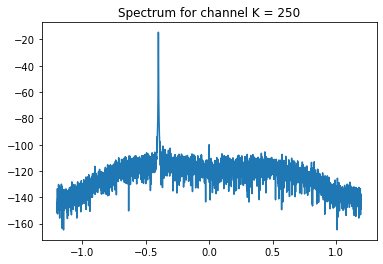

In [11]:
###########################
### Plot single channel ###
###########################
soc.pfb.qout(8)

# ADC Sampling frequency.
fs_adc = soc.adcs['20']['fs']

# ADC Output frequency (x2 decimation).
fs = fs_adc/2

# Channel bandwidth.
fb = fs/(soc.pfb.N/2)

# Channel number.
K = freq2ch(fs=fs, f=fout, N=soc.pfb.N)

[xi,xq] = soc.chsel.transfer(K)
x = xi + 1j*xq

NF = (2**15)*len(x)

w = sp.hanning(len(x))
xw = x*w
F = (np.arange(soc.buff.BUFFER_LENGTH)/soc.buff.BUFFER_LENGTH-0.5)*fb
Y = sp.fftpack.fftshift(sp.fft(xw))
plt.plot(F,20*np.log10(abs(Y)/NF))
plt.title("Spectrum for channel K = %d" %K);

(60, 100)

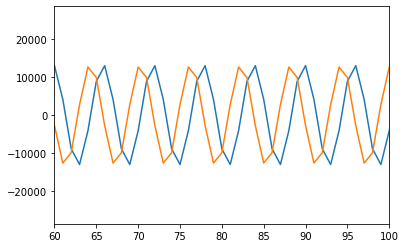

In [12]:
plt.plot(xi)
plt.plot(xq)
#plt.legend(['xi','xq'])
plt.xlim([60,100])

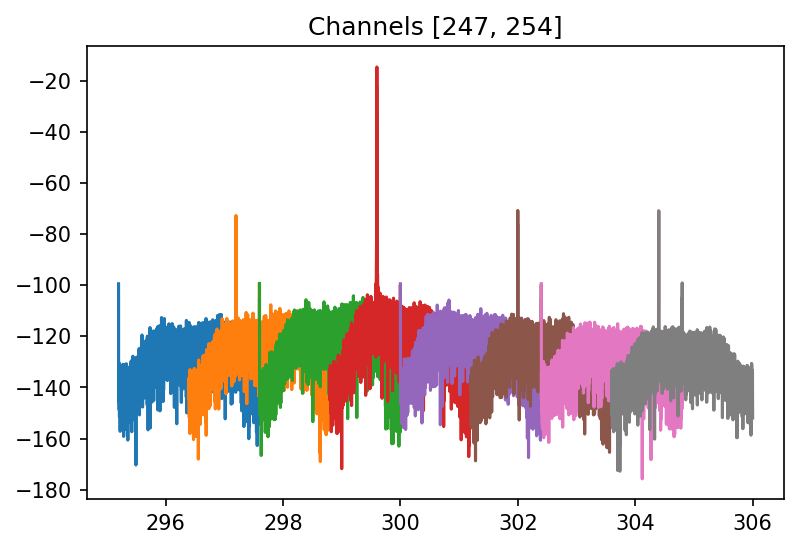

In [25]:
#############################
### Channels Side-by-Side ###
#############################
# Quantization.
soc.pfb.qout(8)

# ADC Sampling frequency.
fs_adc = soc.adcs['20']['fs']

# ADC Output frequency (x2 decimation).
fs = fs_adc/2

# Channel bandwidth.
fb = fs/(soc.pfb.N/2)

# Channel center.
fc = fs/soc.pfb.N

# Channels to plot.
K = np.arange(soc.pfb.N)
K = np.arange(247,255)

# Frequency vector.
F = (np.arange(soc.buff.BUFFER_LENGTH)/soc.buff.BUFFER_LENGTH-0.5)*fb

# Normalization factor.
NF = (2**15)*len(F)

plt.figure(dpi=150)

# Frequency and amplitude vectors.
FF = []
AA = []
for KK in K:
    #print("Iteration K = %d" %KK)
    fck = KK*fc
    
    [xi,xq] = soc.chsel.transfer(KK)
    x = xi + 1j*xq

    w = sp.hanning(len(x))
    xw = x*w
    YY = sp.fftpack.fftshift(sp.fft(xw))
    YYlog = 20*np.log10(abs(YY)/NF)
    AA = np.concatenate((AA,YYlog))
    
    Fk = F+fck
    FF = np.concatenate((FF,Fk))
    plt.plot(Fk,YYlog)
    
# Plot results.
#plt.plot(FF,AA)

# Save figure.
plt.title("Channels [%d, %d]" %(min(K),max(K)))
fn = "spectrum_" + str(min(K)) + "_" + str(max(K)) + ".pdf"
plt.savefig(fn)